250721
 코드는 다음 섹션별로 동작한다

1. 후처리 할 데이터 폴더 선택, 실험넘버, 실험데이터, DAQ connection를 읽는다.
2. driver 압력 강하 순간을 포착하고, 해당 시점으로부터 -1ms ~ 30ms 의 데이터를 잘라서 새로운 엑셀파일로 저장한다.
3. 체크리스트를 불러와서 실험넘버를 검색하여 진공압, 드리븐 압력등을 읽는다.
4. DAQ connection과 체크리스트를 이용하여, 각 계측 전압 데이터를 적절한 단위의 데이터로 변환하여 저장한다.
5. 계축포트 연결 현황을 이용하여 필수 필터를 적용하여 저장한다.
6. driven 7,8 의 압력 상승을 포착한다.
7. DAQ connection에서 model front를 찾아서 압력 상승을 포착한다.
8. driven 8 의 데이터를 보고, 시작점과 끝점을 구간의 RMS를 이용하여 선정한다.
9. -1ms ~ 30ms 의 데이터를 1시트, p1,T1, 등등을 2시트에 기록한 엑셀을 생성한다.



모듈 한번에 받기

In [141]:
import tkinter as tk
from tkinter import filedialog
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

폴더 패스 선택 & 데이터 불러오기

In [142]:
## 폴더 패스 ui로 선택하기

root = tk.Tk()
root.withdraw()  # Tkinter 기본 창 숨기기

folder_path = filedialog.askdirectory(title="엑셀 데이터가 있는 폴더를 선택하세요")

if folder_path:
    print(f"선택된 폴더: {folder_path}")
else:
    print("폴더 선택이 취소되었습니다.")


# ## 폴더 패스 직접 입력하기 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# n='251028 exp#148 HHC 앞뒤 Al 5T driven 0.2barg He M6.8 2.5MHz FL200x2 200-350 TC'
# folder_path = '/Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/pitot and tube pci/'+n


선택된 폴더: /Users/karl/Library/CloudStorage/Dropbox/시흥 실험실/06. Labview log/pitot and tube pci/260123 exp#154 pitot pet150 x5


In [143]:
folder_path

'/Users/karl/Library/CloudStorage/Dropbox/시흥 실험실/06. Labview log/pitot and tube pci/260123 exp#154 pitot pet150 x5'

In [144]:
n='260123 exp#154 pitot pet150 x5'
# 실험 데이터 엑셀 파일명 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
exp_file = n+".xlsx"
exp_file_path = os.path.join(folder_path, exp_file)

# 실험 데이터 두 번째 시트만 가져옴 (sheet_name=1)
exp_data = pd.read_excel(exp_file_path, sheet_name=1)
print(f"{exp_file} 파일 (2번째 시트) 불러오기 완료")
print(exp_data.head())

#맥북 m1 pro 기준 2분 10초 걸림

260123 exp#154 pitot pet150 x5.xlsx 파일 (2번째 시트) 불러오기 완료
       전압_0      전압_1      전압_2      전압_3      전압_4      전압_5      전압_6  \
0  0.000609  0.000857  0.000062  0.000373  0.000653  0.000262  0.000513   
1  0.000297  0.000232 -0.000250  0.000373  0.000653  0.000262  0.000513   
2  0.000609  0.000232  0.000062  0.000061  0.000028 -0.000050  0.000200   
3  0.000609  0.000232 -0.000250  0.000061 -0.000284  0.000262  0.000513   
4  0.000609  0.000232  0.000687  0.000061  0.000341 -0.000050  0.000200   

       전압_7      전압_8      전압_9     전압_10     전압_11     전압_12     전압_13  \
0  0.000368  0.000806  0.000164  0.000063  0.000248  0.000178  0.000136   
1  0.000055  0.000181  0.000789  0.000375 -0.000064  0.000178  0.000136   
2  0.000368  0.000494  0.000789  0.000063  0.000248  0.000178  0.000136   
3  0.000993 -0.000131  0.000476  0.000375  0.000248  0.000178 -0.000489   
4  0.000368  0.000181  0.000164  0.000063  0.000248  0.000178 -0.000489   

      전압_14     전압_15  
0  4.704884  1.429

In [145]:

# DAQ connection 엑셀 파일명 (고정)
DAQ_connection = "DAQ connection.xlsx"
DAQ_connection_path = os.path.join(folder_path, DAQ_connection)

# DAQ connection 불러오기 (기본 첫 번째 시트)
DAQ_connection_data = pd.read_excel(DAQ_connection_path)
print(f"{DAQ_connection} 파일 불러오기 완료")
print(DAQ_connection_data.head())

checklist_path = "/Users/karl/Library/CloudStorage/Dropbox/시흥 실험실/06. Labview log/SHyST Exp Check List ver1.xlsx"
#checklist_path = "/Users/heojeongmu/Dropbox (개인용) (1)/시흥 실험실/06. Labview log/SHyST Exp Check List ver1.xlsx"
#checklist_path = "C:/Users/SHyST/Dropbox/시흥 실험실/06. Labview log/SHyST Exp Check List ver1.xlsx"
# 2번째 행을 key (header) 로 사용
checklist_data = pd.read_excel(checklist_path, header=2)

print("파일 불러오기 완료")
print(checklist_data.head())


DAQ connection.xlsx 파일 불러오기 완료
   # type          PN     SN     cal         a    b          etc filter  \
0  0    P  PCB 132B38  10952  a(V-c)  0.533669  0.0  model front     BP   
1  1    P  PCB 132B38  10953  a(V-c)  0.405755  0.0        model     BP   
2  2    P  PCB 132B38  10954  a(V-c)  0.506799  0.0        model     BP   
3  3    P  PCB 132B38  10955  a(V-c)  0.460219  0.0        model     BP   
4  4    P  PCB 132B38  10956  a(V-c)  0.501017  0.0        model     BP   

  Unnamed: 9  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
파일 불러오기 완료
      #      name      date   test model          Objective  Mach #  \
0  0 예시       허정무  240821.0  porous cone  mack 2nd mode exp    6.76   
1     1       허정무  240826.0    7deg cone          demo prep    6.76   
2     2       허정무  240827.0    7deg cone               demo    6.76   
3     3  허정무, 남준혁  240902.0  porous cone  mack 2nd mode exp    6.76   
4     4       허정무  240904.0  porous cone  mack 2nd mode exp   

In [146]:
# 실험 번호 추출 (문자열 -> 숫자)
exp_num_str = exp_file[11:14]
exp_num = int(exp_num_str)

# checklist_data 에서 해당 실험 번호 찾기
row_checklist = checklist_data[checklist_data['#'] == exp_num]

# 원하는 값 변수에 저장
if not row_checklist.empty:
    p_a = row_checklist.iloc[0]['air pressure(hpa)']/1000
    p_1 = row_checklist.iloc[0]['aimed driven pressure(barg)']+1.
    p_t = row_checklist.iloc[0]['vacuum gauge(Torr)']*0.00133322
    FPS = row_checklist.iloc[0]['DAQ sampling rate']
    T_a= row_checklist.iloc[0]['air temperature(C) ']
else:
    print(f"Check list에서 실험 번호 {exp_num}을 찾을 수 없습니다.")


driver, driven 충격파 시점 찾기

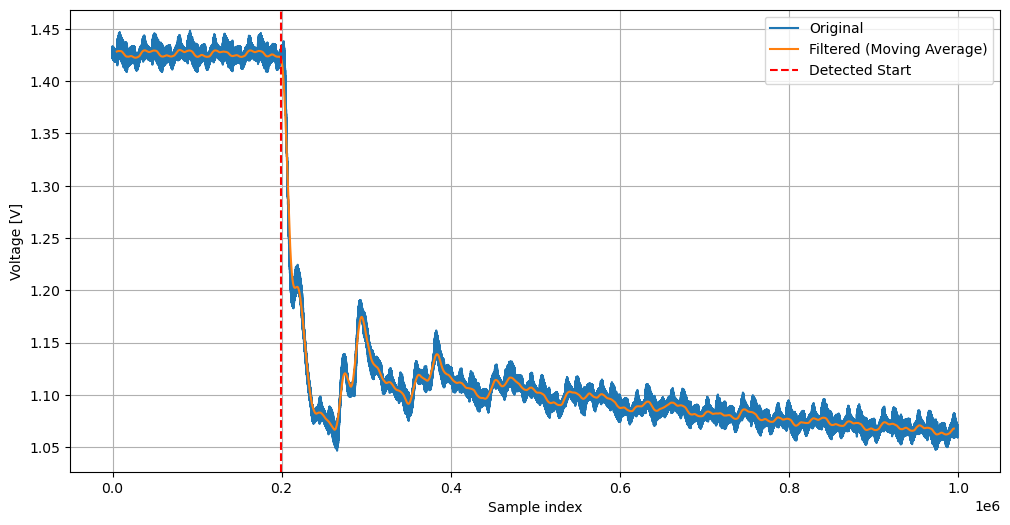

자동 탐색된 driver_index: 199629.00


In [147]:


# 1. driver 채널의 데이터 가져오기
row_driver = DAQ_connection_data[DAQ_connection_data['etc'] == 'driver']

if not row_driver.empty:
    driver_num = row_driver.iloc[0]['#']
    column_name = f'전압_{int(driver_num)}'

    if column_name in exp_data.columns:
        selected_voltage_data = exp_data[column_name]

        # 2. 1000개 이동평균 필터 적용
        window_size = 10000
        filtered_data = selected_voltage_data.rolling(window=window_size, center=True).mean()

        # 3. 초반 10,000개 데이터로 기울기(변화율) 계산
        initial_data = filtered_data.iloc[:10000].dropna()
        gradient = np.diff(initial_data)
        max_gradient = np.max(gradient)
        min_gradient = np.min(gradient)

        # 4. 임계값: 최대 / 최소 기울기 절댓값의 3배
        threshold = 3 * max(abs(max_gradient), abs(min_gradient))

        # 5. 전체 데이터에서 감소 시작점 탐색
        filtered_gradient = np.diff(filtered_data.dropna())
        decline_indices = np.where(filtered_gradient < -threshold)[0]

        if len(decline_indices) > 0:
            decline_index = decline_indices[0]
            driver_index = filtered_data.dropna().index[decline_index] # x축 복원

            # Plot 확인 (선택)
            x_axis = selected_voltage_data.index
            plt.figure(figsize=(12, 6))
            plt.plot(x_axis, selected_voltage_data, label='Original')
            plt.plot(x_axis, filtered_data, label='Filtered (Moving Average)')
            plt.axvline(driver_index, color='r', linestyle='--', label='Detected Start')
            plt.xlabel('Sample index')
            plt.ylabel('Voltage [V]')
            plt.legend()
            plt.grid(True)
            plt.show()

            print(f"자동 탐색된 driver_index: {driver_index:.2f}")
        else:
            raise ValueError("임계값 조건을 만족하는 감소 시작점을 찾을 수 없습니다.")


In [148]:
time_offset_start = -1e-3  # -1 ms
time_offset_end = 30e-3    # 30 ms

# Convert time offset to sample index offset
sample_offset_start = int(time_offset_start * FPS)
sample_offset_end = int(time_offset_end * FPS)

# driver_index는 이미 index 번호임 (1000 나눌 필요 없음)
driver_sample_index = driver_index

# Define slicing index
start_index = driver_sample_index + sample_offset_start
end_index = driver_sample_index + sample_offset_end

# Boundary check
start_index = max(start_index, 0)
end_index = min(end_index, len(exp_data))

# Slice the data
sliced_data = exp_data.iloc[start_index:end_index]

# Save to Excel
save_file = os.path.join(folder_path, exp_file[0:14] + "_sliced_data.xlsx")
sliced_data.to_excel(save_file, index=False)

print(f"Sliced data saved to {save_file}")
#18초 정도 걸림

Sliced data saved to /Users/karl/Library/CloudStorage/Dropbox/시흥 실험실/06. Labview log/pitot and tube pci/260123 exp#154 pitot pet150 x5/260123 exp#154_sliced_data.xlsx


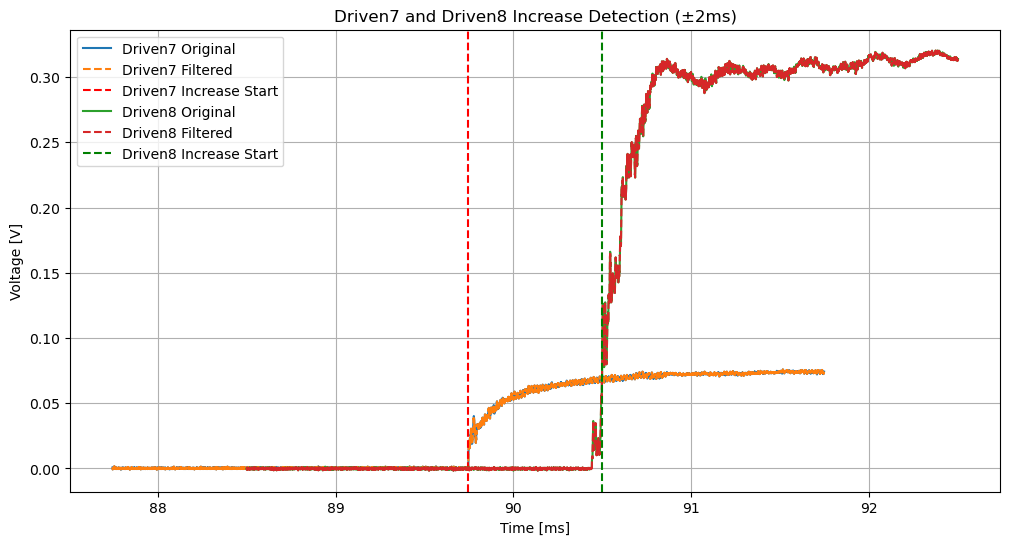

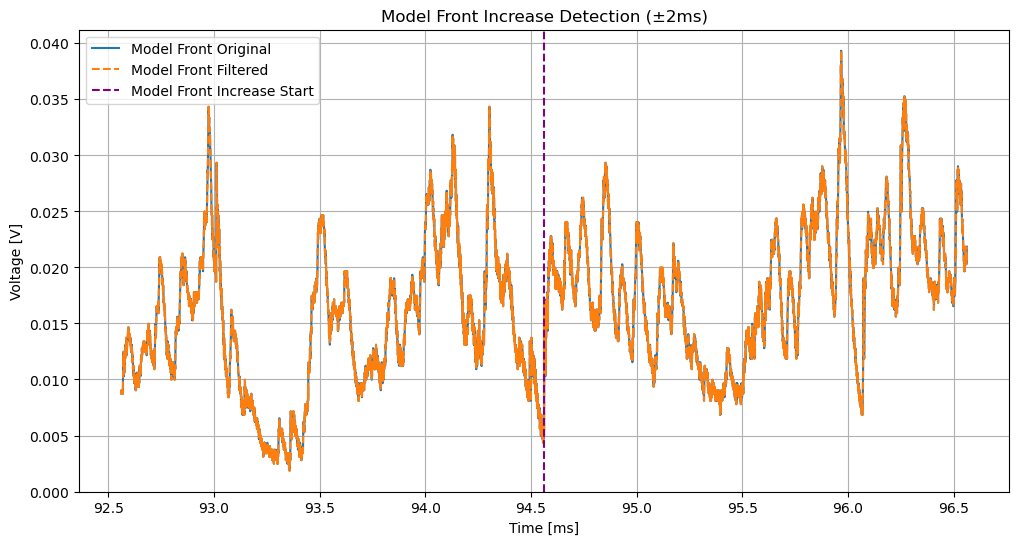

In [149]:
def find_change_index(signal, direction='decrease', fps=FPS, window_size=1, gradient_check_size=10000):
    # 이동평균 필터
    filtered = signal.rolling(window=window_size, center=True).mean()

    # 초기 10000개 기울기
    initial_data = filtered.iloc[:gradient_check_size].dropna()
    gradient = np.diff(initial_data)
    max_gradient = np.max(gradient)
    min_gradient = np.min(gradient)

    # 임계값
    threshold = 3 * max(abs(max_gradient), abs(min_gradient)) #######이거 계수가 클수록 큰 변화를 기준으로

    # 전체 기울기
    filtered_gradient = np.diff(filtered.dropna())
    
    if direction == 'decrease':
        indices = np.where(filtered_gradient < -threshold)[0]
    elif direction == 'increase':
        indices = np.where(filtered_gradient > threshold)[0]
    else:
        raise ValueError("direction 은 'increase' 또는 'decrease' 만 가능")

    if len(indices) > 0:
        change_index = filtered.dropna().index[indices[0]]  # index 그대로 리턴
        return change_index, filtered
    else:
        raise ValueError("변화 시작점을 찾을 수 없습니다.")


# driven7
row_driven7 = DAQ_connection_data[DAQ_connection_data['etc'] == 'driven7']
if not row_driven7.empty:
    driven7_num = row_driven7.iloc[0]['#']
    column_name = f'전압_{int(driven7_num)}'
    selected_voltage_data_7 = exp_data[column_name]
    driven7_index, filtered7 = find_change_index(selected_voltage_data_7, direction='increase')


# driven8
row_driven8 = DAQ_connection_data[DAQ_connection_data['etc'] == 'driven8']
if not row_driven8.empty:
    driven8_num = row_driven8.iloc[0]['#']
    column_name = f'전압_{int(driven8_num)}'
    selected_voltage_data_8 = exp_data[column_name]
    driven8_index, filtered8 = find_change_index(selected_voltage_data_8, direction='increase')


# model front
row_model_front = DAQ_connection_data[DAQ_connection_data['etc'] == 'model front']
if not row_model_front.empty:
    model_front_num = row_model_front.iloc[0]['#']
    column_name = f'전압_{int(model_front_num)}'
    selected_voltage_data_model = exp_data[column_name]
    model_front_index, filtered_model = find_change_index(selected_voltage_data_model, direction='increase')


# 시간 범위 계산
window_ms = 2  # ±1ms
window_sample = int(window_ms / 1000 * FPS)


# driven7
idx7_center = driven7_index
idx7_start = max(idx7_center - window_sample, 0)
idx7_end = min(idx7_center + window_sample, len(selected_voltage_data_7))

x_axis_7 = selected_voltage_data_7.index[idx7_start:idx7_end] / FPS * 1e3  # ms 단위로 변환

plt.figure(figsize=(12, 6))
plt.plot(x_axis_7, selected_voltage_data_7.iloc[idx7_start:idx7_end], label='Driven7 Original')
plt.plot(x_axis_7, filtered7.iloc[idx7_start:idx7_end], linestyle='--', label='Driven7 Filtered')
plt.axvline(driven7_index / FPS * 1e3, color='r', linestyle='--', label='Driven7 Increase Start')

# driven8
idx8_center = driven8_index
idx8_start = max(idx8_center - window_sample, 0)
idx8_end = min(idx8_center + window_sample, len(selected_voltage_data_8))

x_axis_8 = selected_voltage_data_8.index[idx8_start:idx8_end] / FPS * 1e3

plt.plot(x_axis_8, selected_voltage_data_8.iloc[idx8_start:idx8_end], label='Driven8 Original')
plt.plot(x_axis_8, filtered8.iloc[idx8_start:idx8_end], linestyle='--', label='Driven8 Filtered')
plt.axvline(driven8_index / FPS * 1e3, color='g', linestyle='--', label='Driven8 Increase Start')

plt.xlabel('Time [ms]')
plt.ylabel('Voltage [V]')
plt.title('Driven7 and Driven8 Increase Detection (±2ms)')
plt.legend()
plt.grid(True)
plt.show()


# model front
idx_center = model_front_index
idx_start = max(idx_center - window_sample, 0)
idx_end = min(idx_center + window_sample, len(selected_voltage_data_model))

x_axis_model = selected_voltage_data_model.index[idx_start:idx_end] / FPS * 1e3

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x_axis_model, selected_voltage_data_model.iloc[idx_start:idx_end], label='Model Front Original')
plt.plot(x_axis_model, filtered_model.iloc[idx_start:idx_end], linestyle='--', label='Model Front Filtered')
plt.axvline(model_front_index / FPS * 1e3, color='purple', linestyle='--', label='Model Front Increase Start')

plt.xlabel('Time [ms]')
plt.ylabel('Voltage [V]')
plt.title('Model Front Increase Detection (±2ms)')
plt.legend()
plt.grid(True)
plt.show()


전압 데이터를 압력, 온도 등 데이터로 변환

In [150]:
#데이터 변환에 필요한 함수들 선언

def volt_to_celsius_e(volt):
    """
    Convert Type E Thermocouple voltage (Volt) to temperature (°C) using ITS-90 inverse coefficients.
    :param volt: Voltage in volts (V) or numpy array of voltages
    :return: Temperature in Celsius (°C) or numpy array of temperatures
    """
    mv = np.asarray(volt) * 1000  # Convert volts to millivolts (mV), support both scalar and numpy array
    
    # Initialize result array
    celsius = np.zeros_like(mv)
    
    # Coefficients for -200°C ~ 0°C (-8.825 ~ 0 mV)
    coeffs_negative = [0.0000000E+00, 1.6977288E+01, -4.3514970E-01, -1.5859697E-01,
                       -9.2502871E-02, -2.6084314E-02, -4.1360199E-03, -3.4034030E-04,
                       -1.1564890E-05]
    
    # Coefficients for 0°C ~ 1000°C (0 ~ 76.373 mV)
    coeffs_positive = [0.0000000E+00, 1.7057035E+01, -2.3301759E-01, 6.5435585E-03,
                       -7.3562749E-05, -1.7896001E-06, 8.4036165E-08, -1.3735879E-09,
                        1.0629823E-11, -3.2447087E-14]
    
    # Apply coefficients for -200°C ~ 0°C
    mask_negative = (mv >= -8.825) & (mv <= 0)
    celsius[mask_negative] = sum(
        c * mv[mask_negative]**i for i, c in enumerate(coeffs_negative)
    )
    
    # Apply coefficients for 0°C ~ 1000°C
    mask_positive = (mv > 0) & (mv <= 76.373)
    celsius[mask_positive] = sum(
        c * mv[mask_positive]**i for i, c in enumerate(coeffs_positive)
    )
    
    
    return celsius

def volt_to_kelvin_e(volt):
    """
    Convert Type E Thermocouple voltage (Volt) to temperature (Kelvin).
    :param volt: Voltage in volts (V) or numpy array of voltages
    :return: Temperature in Kelvin (K) or numpy array of temperatures
    """
    celsius = volt_to_celsius_e(volt)
    kelvin = celsius + 273.15  # Convert Celsius to Kelvin
    return kelvin


#volt_to_kelvin_e((열전대 측정 및 증폭 값 -5)/500) = ~[K]

def inv_amp(V,V0):
    return (V -V0)/500

def post_process(column_num, column_data, DAQ_connection_data, p_t, p_a):
    row = DAQ_connection_data[DAQ_connection_data['#'] == column_num]
    if row.empty:
        raise ValueError(f"DAQ_connection_data에 {column_num}번 채널 정보 없음.")

    cal_formula = row.iloc[0]['cal']

    # 만약 cal 이 비어있다면 type 을 확인
    if pd.isna(cal_formula):
        ch_type = row.iloc[0]['type']
        if ch_type == 'X':
            return column_data * 0  # 모든 값을 0으로 대체
        else:
            raise ValueError(f"{column_num}번 채널: cal 이 비어있고 type 이 'X'가 아님.")
    
    cal_formula = str(cal_formula).strip()
    a = row.iloc[0]['a']
    b = row.iloc[0]['b']

    # 초반 2500개 평균
    V0 = column_data.iloc[:2500].mean()

    if cal_formula == 'E':
        return volt_to_kelvin_e(inv_amp(column_data, V0))
    elif cal_formula == 'aV+b':
        return a * column_data + b
    elif cal_formula == 'p_t+a(V-c)+b':
        return p_t + a * (column_data - V0) + b
    elif cal_formula == 'p_a+aV+b':
        return p_a + a * column_data + b
    elif cal_formula == 'a(V-c)':
        return a * (column_data - V0)
    else:
        raise ValueError(f"알 수 없는 후처리 수식: {cal_formula}")



In [151]:
# 변환 실시 (sliced_data 기준)
processed_data = {}

for column_name in sliced_data.columns:
    if '전압_' in column_name:
        column_num = int(column_name.replace('전압_', ''))
        processed_column = post_process(column_num, sliced_data[column_name], DAQ_connection_data, p_t=p_1, p_a=p_a)
        processed_data[column_name] = processed_column


In [152]:
#변환된 데이터 저장

# dict -> DataFrame 변환
processed_df = pd.DataFrame(processed_data)

# 파일 경로 및 파일명 설정
save_file = os.path.join(folder_path, exp_file[0:14] + "_sliced_data_PT.xlsx")

# 엑셀로 저장
processed_df.to_excel(save_file, index=False)

print(f"Sliced processed data saved to {save_file}")

#17초 

Sliced processed data saved to /Users/karl/Library/CloudStorage/Dropbox/시흥 실험실/06. Labview log/pitot and tube pci/260123 exp#154 pitot pet150 x5/260123 exp#154_sliced_data_PT.xlsx


필수 필터링 하기

In [153]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def lowpass_filter(data, cutoff_hz, fs):
    b, a = butter(N=4, Wn=cutoff_hz / (0.5 * fs), btype='low')
    return filtfilt(b, a, data)

def bandpass_filter(data, lowcut_hz, highcut_hz, fs):
    b, a = butter(N=4, Wn=[lowcut_hz / (0.5 * fs), highcut_hz / (0.5 * fs)], btype='band')
    return filtfilt(b, a, data)

In [154]:
filtered_data = {}

for column_name in processed_data:
    column_num = int(column_name.replace('전압_', ''))
    row = DAQ_connection_data[DAQ_connection_data['#'] == column_num]

    if row.empty:
        raise ValueError(f"DAQ_connection_data에 {column_num}번 채널 정보 없음.")

    pn_value = row.iloc[0]['PN']
    data = processed_data[column_name]

    if pn_value == 'medtherm thermocouple':
        filtered = moving_average(data, window_size=300)  #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

    elif pn_value == 'PCB 113B22':
        filtered = lowpass_filter(data, cutoff_hz=500e3, fs=FPS)

    elif pn_value == 'PCB 132B38':
        filtered = bandpass_filter(data, lowcut_hz=11e3, highcut_hz=1e6, fs=FPS)

    else:
        # 조건에 없는 경우 그대로 사용
        filtered = data

    filtered_data[column_name] = filtered


/var/folders/xc/y24wwn3j73b9d2tqk7s9_35h0000gn/T/ipykernel_40568/4265227685.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


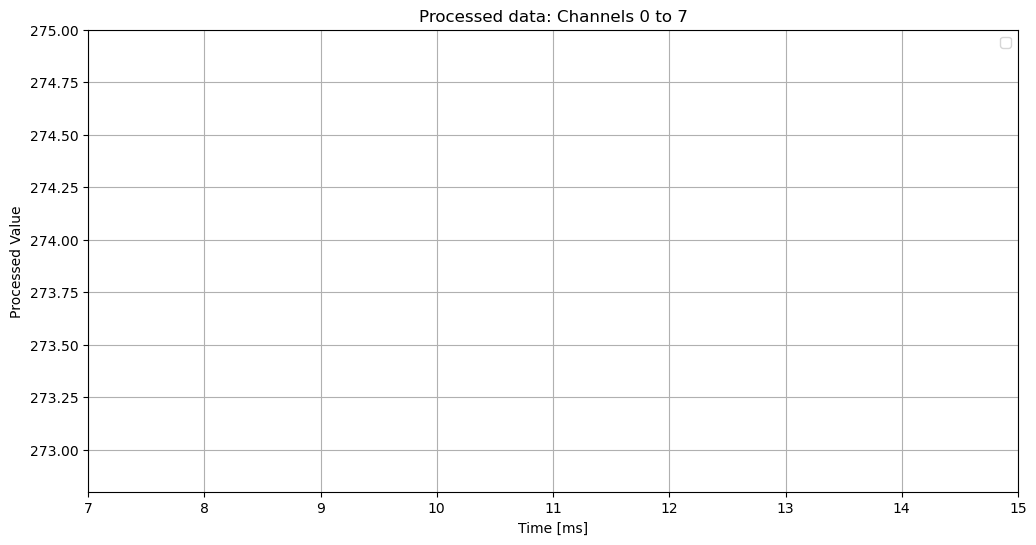

In [155]:
#데이터 살펴보기

plt.figure(figsize=(12, 6))

time_axis_ms = np.arange(len(next(iter(filtered_data.values())))) / FPS * 1000-1  # ms

for i in range(16,24):
    column_name = f'전압_{i}'
    if column_name in filtered_data:
        plt.plot(time_axis_ms, filtered_data[column_name], label=i)

plt.xlabel("Time [ms]")
plt.ylabel("Processed Value")
plt.title("Processed data: Channels 0 to 7")
plt.legend()
plt.grid(True)
plt.xlim(7,15) # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
plt.ylim(272.8,275) # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
plt.show()


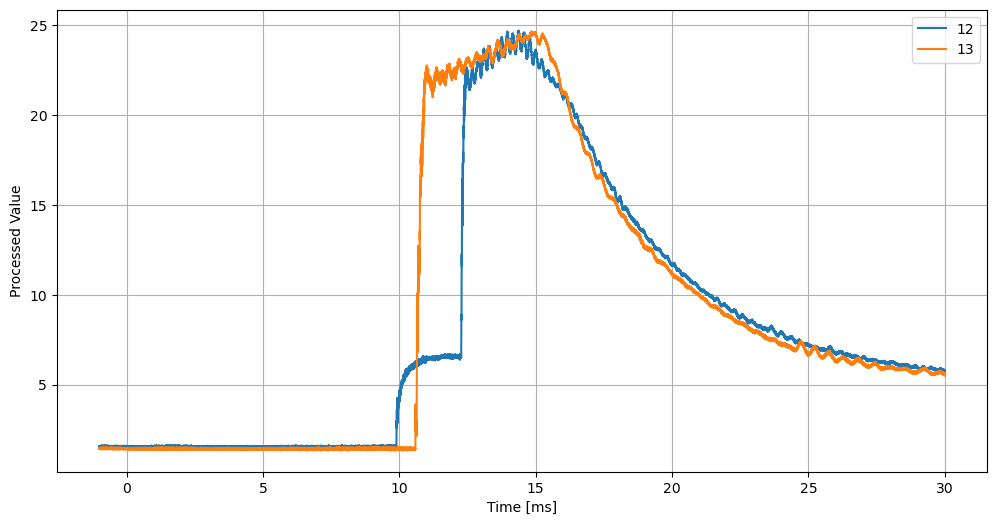

In [156]:
plt.figure(figsize=(12, 6))

for i in range(12,14):
    column_name = f'전압_{i}'
    if column_name in filtered_data:
        plt.plot(time_axis_ms, filtered_data[column_name], label=i)

plt.xlabel("Time [ms]")
plt.ylabel("Processed Value")

plt.legend()
plt.grid(True)
plt.show()

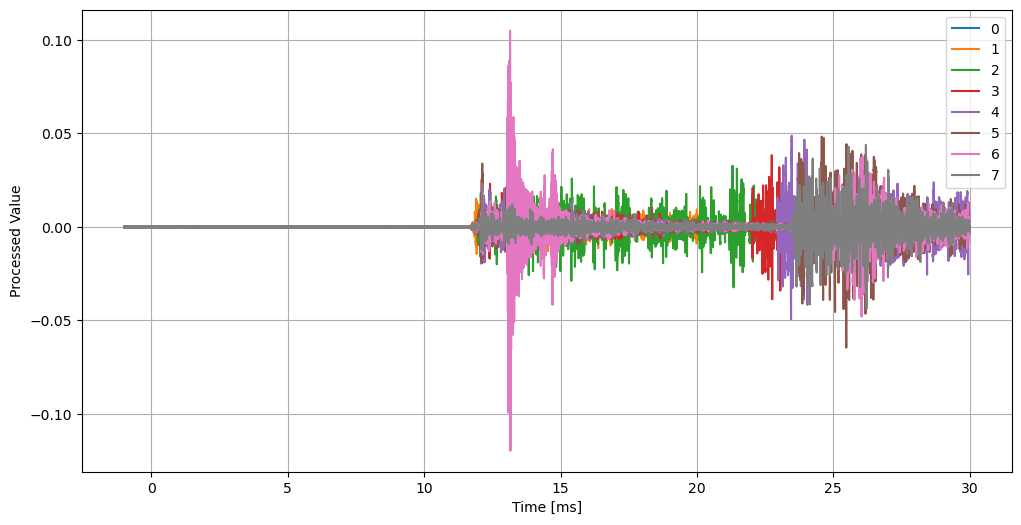

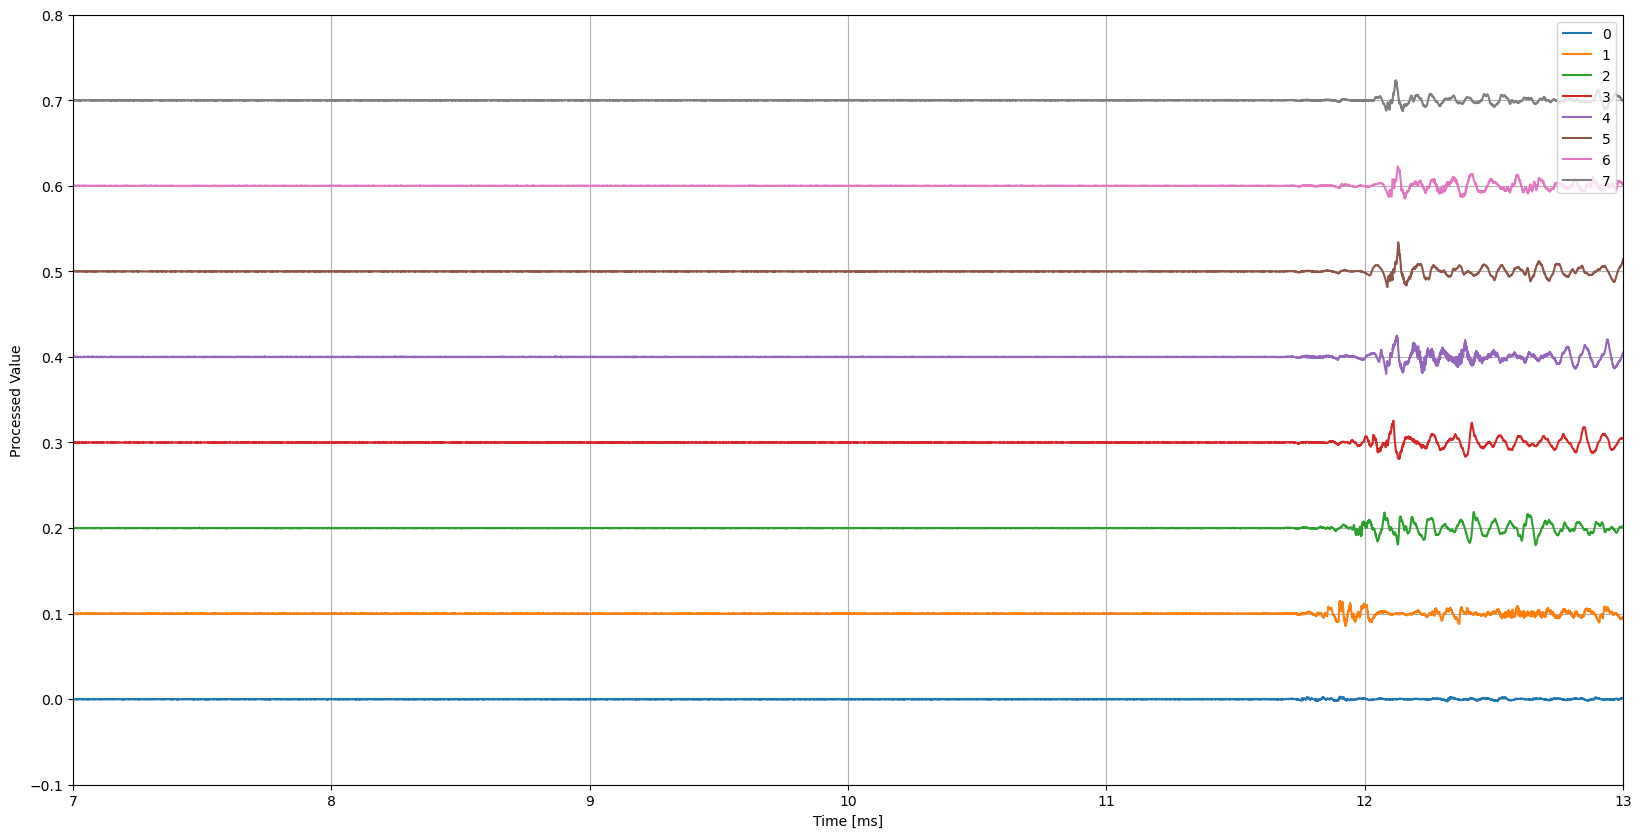

In [157]:
plt.figure(figsize=(12, 6))

for i in range(0,8):
    column_name = f'전압_{i}'
    if column_name in filtered_data:
        plt.plot(time_axis_ms, filtered_data[column_name], label=i)

plt.xlabel("Time [ms]")
plt.ylabel("Processed Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 10))
for i in range(0,8):
    column_name = f'전압_{i}'
    if column_name in filtered_data:
        plt.plot(time_axis_ms, filtered_data[column_name]+0.1*(i), label=i)

plt.xlabel("Time [ms]")
plt.ylabel("Processed Value")
plt.legend()
plt.grid(True)
plt.xlim(7,13) # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
plt.ylim(-0.1,0.8) # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
plt.show()

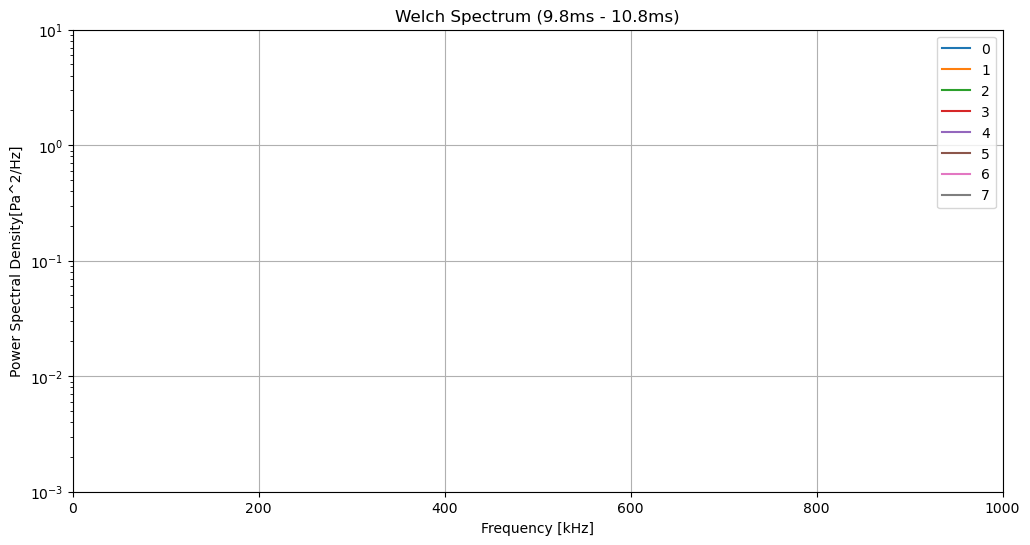

In [158]:
from scipy.signal import welch
import matplotlib.pyplot as plt

# 시간 범위 [ms]
t_start_ms = 9.8
t_end_ms = t_start_ms+1

# 시간 인덱스 계산
start_index = int(t_start_ms / 1000 * FPS)
end_index = int(t_end_ms / 1000 * FPS)

plt.figure(figsize=(12, 6))

for i in range(0,8):
    column_name = f'전압_{i}'
    if column_name in filtered_data:
        data_segment = filtered_data[column_name][start_index:end_index]*1e5

        # Welch 주파수 분석
        freqs, psd = welch(data_segment, fs=FPS, nperseg=128)

        # Plot in kHz
        plt.semilogy(freqs / 1e3, psd, label=i)

plt.xlabel("Frequency [kHz]")
plt.ylabel("Power Spectral Density[Pa^2/Hz]")
plt.title(f"Welch Spectrum ({t_start_ms}ms - {t_end_ms}ms)")
plt.legend()
plt.grid(True)
plt.xlim(0,1000)
plt.ylim(1e-3,1e+1)
plt.show()


In [159]:
# dict -> DataFrame 변환
filtered_df = pd.DataFrame(filtered_data)

# 파일 경로 및 파일명 설정
save_file = os.path.join(folder_path, exp_file[0:14] + "_sliced_data_PT_filtered.xlsx")

# 엑셀로 저장
filtered_df.to_excel(save_file, index=False)

print(f"Sliced filtered data saved to {save_file}")

#19초

Sliced filtered data saved to /Users/karl/Library/CloudStorage/Dropbox/시흥 실험실/06. Labview log/pitot and tube pci/260123 exp#154 pitot pet150 x5/260123 exp#154_sliced_data_PT_filtered.xlsx


시험시간 정하기

/var/folders/xc/y24wwn3j73b9d2tqk7s9_35h0000gn/T/ipykernel_40568/2410266079.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


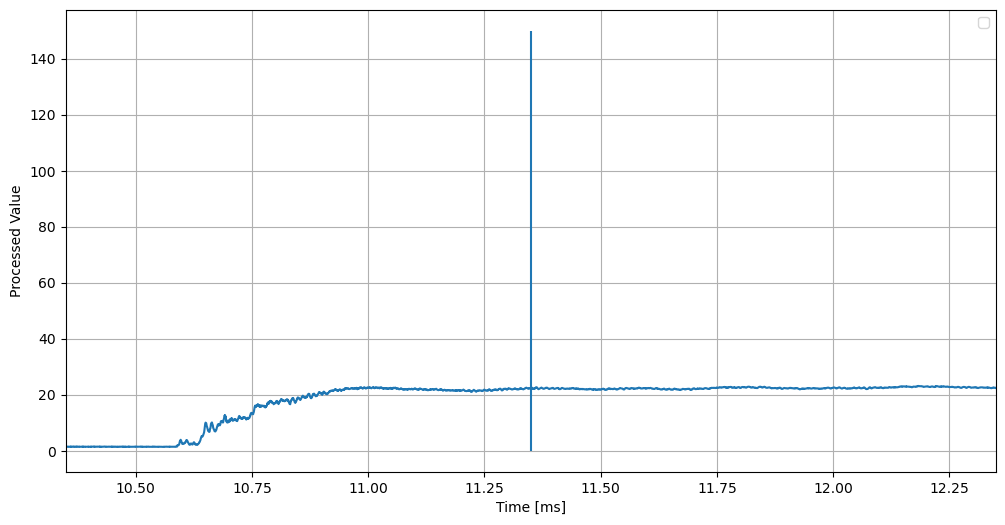

In [180]:
test_time_start=11.35 #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

time_axis_ms = np.arange(len(next(iter(filtered_data.values())))) / FPS * 1000-1  # ms

plt.figure(figsize=(12, 6))

column_name = '전압_'+str(driven8_num)

plt.plot(time_axis_ms, filtered_data[column_name])
plt.vlines(x=test_time_start,ymin=0,ymax=150)


plt.xlabel("Time [ms]")
plt.ylabel("Processed Value")

plt.legend()
plt.grid(True)
plt.xlim(test_time_start-1,test_time_start+1)

plt.show()

In [181]:
rms_list=[]

for i in range(0,10*2500):
    rms_list.append(np.std(np.array(filtered_data[column_name])[int((test_time_start+1)*2500):int((test_time_start+1)*2500)+i]/np.mean(np.array(filtered_data[column_name])[int((test_time_start+1)*2500):int((test_time_start+1)*2500)+i])))


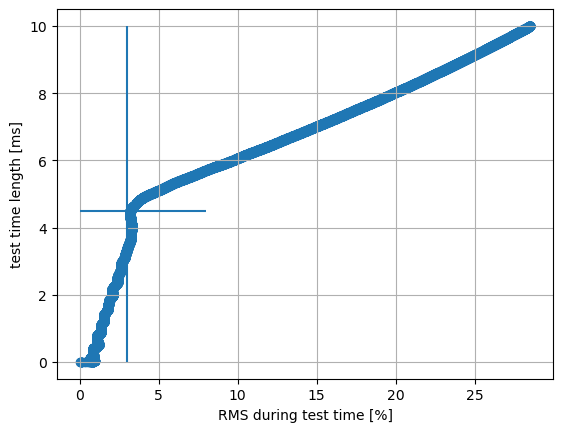

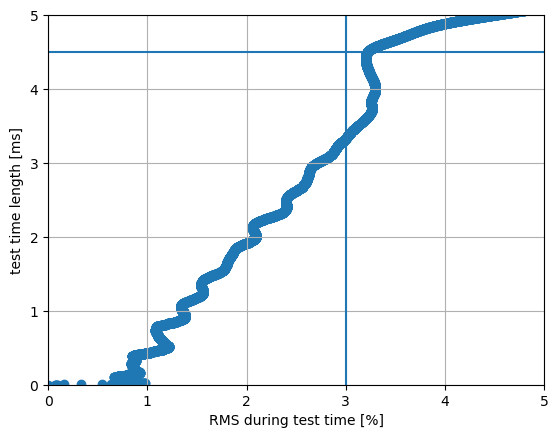

/var/folders/xc/y24wwn3j73b9d2tqk7s9_35h0000gn/T/ipykernel_40568/53451088.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


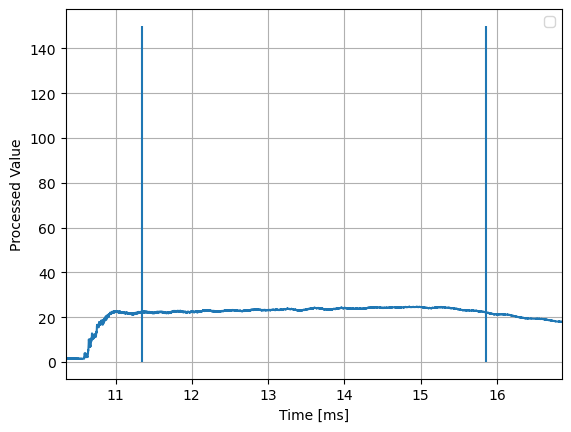

In [182]:
test_time_length=4.5 #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@



plt.scatter(np.array(rms_list)*100,np.linspace(0,10,10*2500))
plt.vlines(x=3,ymin=0,ymax=10)
plt.hlines(y=test_time_length,xmin=0,xmax=8)
plt.grid(True)
plt.xlabel("RMS during test time [%]")
plt.ylabel("test time length [ms]")
plt.show()

plt.scatter(np.array(rms_list)*100,np.linspace(0,10,10*2500))
plt.vlines(x=3,ymin=0,ymax=5)
plt.hlines(y=test_time_length,xmin=0,xmax=5)
plt.xlim(0,5)
plt.ylim(0,5)
plt.grid(True)
plt.xlabel("RMS during test time [%]")
plt.ylabel("test time length [ms]")
plt.show()

plt.plot(time_axis_ms, filtered_data[column_name])
plt.vlines(x=test_time_start,ymin=0,ymax=150)
plt.vlines(x=test_time_start+test_time_length,ymin=0,ymax=150)
plt.xlabel("Time [ms]")
plt.ylabel("Processed Value")
plt.legend()
plt.grid(True)
plt.xlim(test_time_start-1,test_time_start+test_time_length+1)

plt.show()

In [183]:
# 3. shock_speed (m/s)
driven7_time_sec = (driven7_index - driver_index) /FPS  # [sec]
driven8_time_sec = (driven8_index - driver_index) /FPS  # [sec]
delta_t_sec = driven8_time_sec - driven7_time_sec

distance = 0.5  # [m]
shock_speed = distance / delta_t_sec


# 4. output_delay_time [ms]
model_front_time_sec = (model_front_index - driver_index) /FPS  # [sec]
output_delay_time = (model_front_time_sec - driven8_time_sec) * 1000  # [ms]


# 5. output_ready_time [ms]
output_ready_time = test_time_start - driven8_time_sec * 1000  # [ms]


# 6. first diaphragm rupture [ms]
first_diaphragm_rupture = 0.0


# 7. second diaphragm rupture [ms]
second_diaphragm_rupture = driven8_time_sec * 1000  # [ms]


# 8. test_time_end [ms]
test_time_end = test_time_start + test_time_length


# 9. model_front_time [ms]
model_front_time = model_front_time_sec * 1000  # [ms]

p_4 = filtered_data['전압_' + str(driver_num)].iloc[:2500].mean()

p_5s = filtered_data['전압_' + str(driven8_num)].loc[int(driver_index+test_time_start*FPS/1000):int(driver_index+test_time_end*FPS/1000)].mean()

p_5s_std = filtered_data['전압_' + str(driven8_num)].loc[int(driver_index+test_time_start*FPS/1000):int(driver_index+test_time_end*FPS/1000)].std()

In [184]:
print(f"p_4: {p_4}")
print(f"p_5s: {p_5s}")
print(f"p_5s_std: {p_5s_std}")
print(f"shock_speed: {shock_speed} m/s")
print(f"output_delay_time: {output_delay_time} ms")
print(f"output_ready_time: {output_ready_time} ms")
print(f"first_diaphragm_rupture: {first_diaphragm_rupture} ms")
print(f"second_diaphragm_rupture: {second_diaphragm_rupture} ms")
print(f"test_time_start: {test_time_start} ms")
print(f"test_time_end: {test_time_end} ms")
print(f"model_front_time: {model_front_time} ms")


p_4: 32.57495320219563
p_5s: 23.36796555209927
p_5s_std: 0.7527665200255598
shock_speed: 664.1870350690757 m/s
output_delay_time: 4.063199999999999 ms
output_ready_time: 0.702399999999999 ms
first_diaphragm_rupture: 0.0 ms
second_diaphragm_rupture: 10.6476 ms
test_time_start: 11.35 ms
test_time_end: 15.85 ms
model_front_time: 14.710799999999999 ms


In [ ]:
import pandas as pd
import os

# 데이터 준비 (1행짜리 DataFrame으로 만듦)
result_data = {
    'p4_avg[bar]': [p_4],
    'p5_avg[bar]': [p_5s],
    'p5_std[bar]': [p_5s_std],
    'test_time[ms]': [test_time_length],
    'shock_speed[m/s]': [shock_speed],
    'output_delay_time[ms]': [output_delay_time],
    'output_ready_time[ms]': [output_ready_time],
    'first diaphragm rupture[ms]': [first_diaphragm_rupture],
    'second diaphragm rupture[ms]': [second_diaphragm_rupture],
    'test time start(nozzle reservoir)[ms]': [test_time_start],
    'test time end(nozzle reservoir)[ms]': [test_time_end],
    'cone_shock_time[ms]': [model_front_time]
}

result_df = pd.DataFrame(result_data)

# 파일 경로 설정
save_file = os.path.join(folder_path, exp_file[0:14] + "_parameters.xlsx")

# 엑셀로 저장
result_df.to_excel(save_file, index=False)

print(f"Summary data saved to {save_file}")


Summary data saved to /Users/karl/Library/CloudStorage/Dropbox/시흥 실험실/06. Labview log/pitot and tube pci/260123 exp#154 pitot pet150 x5/260123 exp#154_parameters.xlsx


: 